In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [33]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [34]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
# rename columns to something better
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [36]:
sentences = df['data']

import tensorflow_datasets as tfds

vocab_size = 20000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, 
                                                                      vocab_size, 
                                                                      max_subword_length=5)
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [38]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(sentences, Y, test_size=0.33)

In [40]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(df_train)
print('Shape of data train tensor:', data_train.shape)
# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 262)


In [41]:
data_test = pad_sequences(df_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 262)


In [42]:
df_train.head(5)

540     [63, 166, 12663, 11771, 6881, 4933, 12663, 509...
4264    [153, 50, 12676, 746, 687, 12655, 52, 92, 30, ...
4256    [798, 877, 980, 1495, 31, 61, 2238, 9, 3521, 4...
2196    [298, 641, 3, 69, 139, 2190, 12727, 12552, 111...
3905    [3223, 1826, 2699, 1075, 365, 12663, 147, 654,...
Name: data, dtype: object

In [43]:
# Create the model
V = vocab_size + 1
# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))              # T is length of each line Text
x = Embedding(V, D)(i)     # V is total size of vocabulary words
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)


In [44]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 [==============================] - 4s 23ms/step - loss: 0.5334 - accuracy: 0.8695 - val_loss: 0.3849 - val_accuracy: 0.8684
Epoch 2/10
117/117 [==============================] - 2s 19ms/step - loss: 0.3774 - accuracy: 0.8648 - val_loss: 0.2980 - val_accuracy: 0.8684
Epoch 3/10
117/117 [==============================] - 2s 19ms/step - loss: 0.2687 - accuracy: 0.8520 - val_loss: 0.2013 - val_accuracy: 0.8766
Epoch 4/10
117/117 [==============================] - 2s 19ms/step - loss: 0.1489 - accuracy: 0.9569 - val_loss: 0.1667 - val_accuracy: 0.9619
Epoch 5/10
117/117 [==============================] - 2s 19ms/step - loss: 0.0856 - accuracy: 0.9921 - val_loss: 0.1411 - val_accuracy: 0.9625
Epoch 6/10
117/117 [==============================] - 2s 19ms/step - loss: 0.0653 - accuracy: 0.9898 - val_loss: 0.1143 - val_accuracy: 0.9706
Epoch 7/10
117/117 [==============================] - 2s 19ms/step - loss: 0.0427 - accuracy: 0.9943 - val_loss: 0.1014 - va

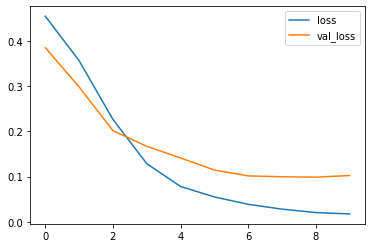

In [45]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

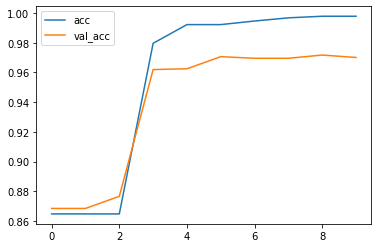

In [46]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [47]:
from sklearn.metrics import classification_report,confusion_matrix
y_prediction = np.argmax(model.predict(data_test), axis=-1)
print(classification_report(Ytest,y_prediction))
print(confusion_matrix(Ytest,y_prediction))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1597
           1       0.00      0.00      0.00       242

    accuracy                           0.87      1839
   macro avg       0.43      0.50      0.46      1839
weighted avg       0.75      0.87      0.81      1839

[[1597    0]
 [ 242    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(y_prediction != Ytest)[0]
i = np.random.choice(misclassified_idx)
# Separately print out each subword, decoded
for d in data_test[i]:
  print(tokenizer.decode([d]))   # now decode the number to text
print("Spam label: %s but predicted: %s" % (Ytest[i], y_prediction[i]))

In [30]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

def predict_review(model, new_sentences, maxlen, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [31]:
# Predicting Sentiment in New Reviews Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes',
                'bats are all wearing underwears with tie',
                'bat was runnig the show',
                'does not work when I stand on my head']

print(fake_reviews) 

predict_review(model, fake_reviews, T)


['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'bats are all wearing underwears with tie', 'bat was runnig the show', 'does not work when I stand on my head']
[  5 167  73 115   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0